<h1 align=center><font size = 5> SVM (Support Vector Machines)</font></h1>

# Aula 9 - Treinamento Machine Learning - FIAP + Alura

## Demo 13 - Artificial Intelligence Tools & Examples - Machine Learning - Aprendizagem Supervisionada - Algoritmo SVM (Support Vector Machines)

Prof. Dr. Ahirton Lopes (profahirton.lopes@fiap.com.br)

### Objetivo

Vamos a usar a técnica SVM (Support Vector Machines) para construir e treinar um modelo usando registros de células humanas e classificar as células se as amostras são benignas ou malignas.

O SVM funciona mapeando dados para um espaço de recursos de alta dimensão para que os pontos de dados possam ser categorizados, mesmo quando os dados não são linearmente separáveis.

In [1]:
!pip install kaggle

In [2]:
import os

# Configuração do diretório do Kaggle
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

# Baixar o conjunto de dados Cell Samples
!kaggle datasets download -d sam1o1/cell-samplescsv

!unzip cell-samplescsv.zip

Dataset URL: https://www.kaggle.com/datasets/sam1o1/cell-samplescsv
License(s): unknown
  0% 0.00/5.80k [00:00<?, ?B/s]
100% 5.80k/5.80k [00:00<00:00, 9.01MB/s]
Archive:  cell-samplescsv.zip
  inflating: cell_samples.csv        


In [3]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt

### Carregando nossos dados

In [4]:
cell_df = pd.read_csv("cell_samples.csv")
cell_df.head()
# np.unique(cell_df.Class)

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


O campo Classe contém o diagnóstico, confirmado por procedimentos médicos separados, se as amostras são benignas (valor = 2) ou malignas (valor = 4).

Vejamos a distribuição das classes com base na espessura da aglomeração e na uniformidade do tamanho da célula:

<Axes: xlabel='Clump', ylabel='UnifSize'>

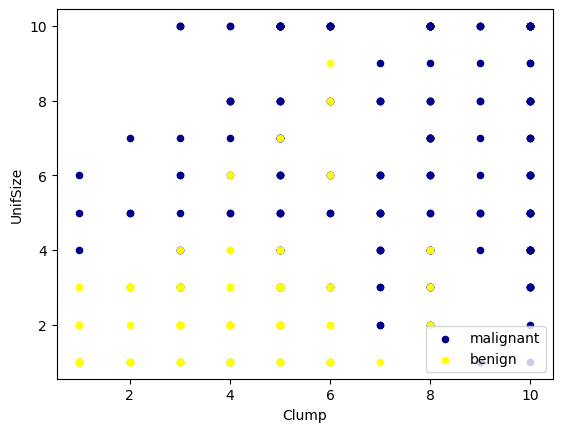

In [5]:
ax1 = cell_df[cell_df['Class'] == 4].plot(kind='scatter', x='Clump', y='UnifSize', color='DarkBlue', label='malignant')
cell_df[cell_df['Class'] == 2].plot(kind='scatter', x='Clump', y='UnifSize', color='Yellow', label='benign', ax=ax1)
# plt.show()

## Pré processamento de dados e seleção de atributos

Vejamos primeiro os tipos de dados das colunas:

In [6]:
cell_df.dtypes

,0
ID,int64
Clump,int64
UnifSize,int64
UnifShape,int64
MargAdh,int64
SingEpiSize,int64
BareNuc,object
BlandChrom,int64
NormNucl,int64
Mit,int64


Parece que a coluna __BareNuc__ inclui alguns valores que não são numéricos.

Podemos eliminar essas linhas:

In [7]:
cell_df = cell_df[pd.to_numeric(cell_df['BareNuc'], errors='coerce').notnull()]
cell_df['BareNuc'] = cell_df['BareNuc'].astype('int')
cell_df.dtypes

<ipython-input-7-df8bc795062c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_df['BareNuc'] = cell_df['BareNuc'].astype('int')


,0
ID,int64
Clump,int64
UnifSize,int64
UnifShape,int64
MargAdh,int64
SingEpiSize,int64
BareNuc,int64
BlandChrom,int64
NormNucl,int64
Mit,int64


In [8]:
feature_df = cell_df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
X = np.asarray(feature_df)
X[0:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]])

Queremos que o modelo preveja o valor da Classe (ou seja, benigno (=2) ou maligno (=4)). Como este campo pode ter um de apenas dois valores possíveis, precisamos alterar o seu nível de medição para refletir isso.

In [9]:
cell_df['Class'] = cell_df['Class'].astype('int')
y = np.asarray(cell_df['Class'])
np.unique(y)

array([2, 4])

## Dataset de Treino/Teste

Ok, agora dividimos nosso conjunto de dados em conjunto de treinamento e teste:

In [10]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (546, 9) (546,)
Test set: (137, 9) (137,)


# Modelagem (SVM com Scikit-learn)

O algoritmo SVM oferece uma escolha de funções de kernel para realizar seu processamento. Basicamente, o mapeamento de dados em um espaço de dimensão superior é chamado de kernelling. A função matemática utilizada para a transformação é conhecida como função kernel, e pode ser de diversos tipos, como:

 1.Linear
 2. Polinominal
 3. Função de base radial (RBF)
 4.Sigmóide

Cada uma dessas funções tem suas características, seus prós e contras e sua equação, mas como não há uma maneira fácil de saber qual função tem melhor desempenho com qualquer conjunto de dados, geralmente escolhemos funções diferentes e comparamos os resultados. Vamos apenas usar o padrão RBF (Radial Basis Function) para este laboratório.

In [11]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

SVC()

Depois de ajustado, o modelo pode então ser usado para prever novos valores:

In [12]:
yhat = clf.predict(X_test)
yhat [0:5]

array([2, 4, 2, 4, 2])

## Avaliação

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           2       1.00      0.94      0.97        90
           4       0.90      1.00      0.95        47

    accuracy                           0.96       137
   macro avg       0.95      0.97      0.96       137
weighted avg       0.97      0.96      0.96       137

Confusion matrix, without normalization
[[85  5]
 [ 0 47]]


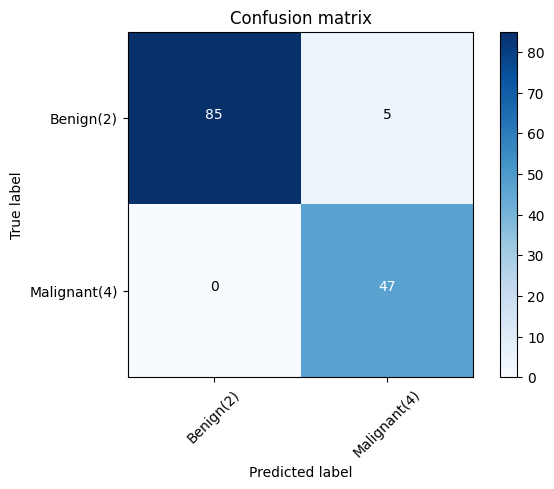

In [15]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(2)','Malignant(4)'],normalize= False,  title='Confusion matrix')

Você também pode usar facilmente o __f1_score__ da biblioteca sklearn:

In [16]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted')

0.9639038982104676

In [17]:
clf2 = svm.SVC(kernel='linear')
clf2.fit(X_train, y_train)
yhat2 = clf2.predict(X_test)
print("Avg F1-score: %.4f" % f1_score(y_test, yhat2, average='weighted'))

Avg F1-score: 0.9639
